## I use syntehtic_digits applicatoin to create synthetic digits and labels and save them in the given files.  

In [1]:
import os
from model import train, model
import create_synthetic_digits

imsize = model.IMSIZE
images_file = 'DIGITS/digits.data'
labels_file = 'DIGITS/labels.data'
create_synthetic_digits.create_images_and_labels(images_file, labels_file, imsize )



In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 45


In [3]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from collections import Counter
class myDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.digits = np.loadtxt(images_file,dtype=float)
        self.labels = np.loadtxt(labels_file).astype(int)-1
        self.digits = np.reshape(self.digits,(-1,imsize,imsize))
        self.digits = np.array([np.expand_dims(d,2) for d in self.digits])
        c = Counter(self.labels) 
        print(c)
    def __len__(self):
        return len(self.digits)

    def __getitem__(self, idx):
        digit = self.digits[idx]
        if self.transform:
            digit = self.transform(np.uint8(digit))
            digit = self.transform(digit)
        else:
            transform = transforms.ToTensor()
            digit = transform(digit)
        return digit, self.labels[idx]    


In [4]:
train_transform  = transforms.Compose([transforms.ToPILImage(),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.8, interpolation=3),
        transforms.ToTensor()])
train_dataset = myDataset(transform=train_transform)
train_dataset.classes = ['1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Counter({0: 110, 1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110})


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
        num_workers=num_workers, shuffle=True)

/home/rocio/work/anaconda3/envs/computer-vision/lib/python3.7/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]


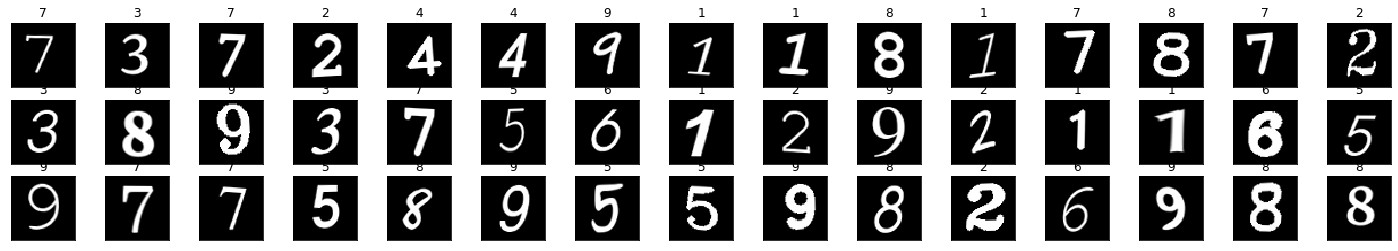

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(45):
    ax = fig.add_subplot(3, 15, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()+1))
    

In [7]:
model1 = model.CNNet()
#model1.load_state_dict(torch.load('best_model.pth'))
model1.train()

CNNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=9, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [8]:
epochs = 4000
learning_rate = 0.005
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train.train(model1, train_loader, epochs, device, learning_rate, momentum,  "best_model.pth", first_epoch = 1)

Epoch: 200, CELoss: 0.000851
Epoch: 400, CELoss: 0.000197
Epoch: 600, CELoss: 0.001809
Epoch: 800, CELoss: 0.000128
Epoch: 1000, CELoss: 0.000017
Epoch: 1200, CELoss: 0.003193
Epoch: 1400, CELoss: 0.000209
Epoch: 1600, CELoss: 0.000003
Epoch: 1800, CELoss: 0.000012
Epoch: 2000, CELoss: 0.000058
Epoch: 2200, CELoss: 0.000395
Epoch: 2400, CELoss: 0.000006
Epoch: 2600, CELoss: 0.000004
Epoch: 2800, CELoss: 0.000001
Epoch: 3000, CELoss: 0.000101
Epoch: 3200, CELoss: 0.000003
Epoch: 3400, CELoss: 0.000001
Epoch: 3600, CELoss: 0.000030
Epoch: 3800, CELoss: 0.000681
Epoch: 4000, CELoss: 0.000943


In [9]:
train_transform  = transforms.Compose([transforms.ToPILImage(),
        transforms.RandomPerspective(distortion_scale=0.2, p=1, interpolation=3),
        transforms.ToTensor()])
test_dataset = myDataset(transform=train_transform)
test_dataset.classes = ['1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=num_workers, shuffle=True)

Counter({0: 110, 1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110})


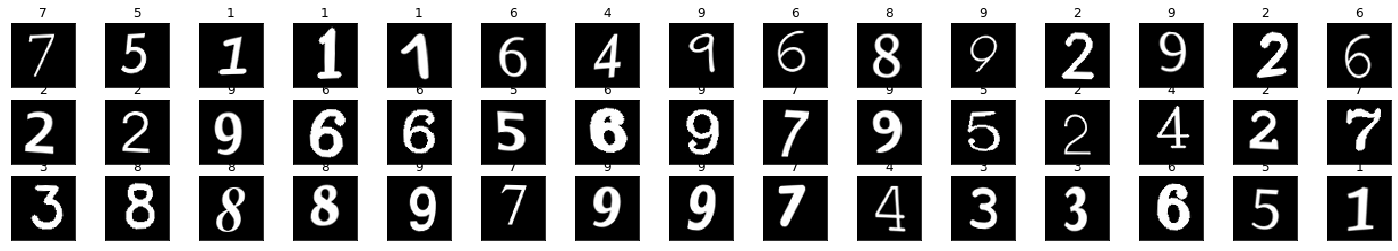

In [10]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(45):
    ax = fig.add_subplot(3, 15, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()+1))

In [11]:
criterion = torch.nn.CrossEntropyLoss()
    
test_loss = 0.0
class_correct = list(0. for i in range(9))
class_total = list(0. for i in range(9))

model1.to(device)
model1.eval() # prep model for *evaluation*

for batch in train_loader:
    batch_X, batch_y = batch

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    model1.zero_grad()
    output = model1(batch_X)
    loss = criterion(output, batch_y) 
    
    test_loss += loss.item()*batch_X.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(batch_y.data.view_as(pred)))

    for i in range(len(batch_y)):
        label = batch_y.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(9):
    print(i)
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i+1), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (test_dataset.classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000000

0
Test Accuracy of     1: 100% (110/110)
1
Test Accuracy of     2: 100% (110/110)
2
Test Accuracy of     3: 100% (110/110)
3
Test Accuracy of     4: 100% (110/110)
4
Test Accuracy of     5: 100% (110/110)
5
Test Accuracy of     6: 100% (110/110)
6
Test Accuracy of     7: 100% (110/110)
7
Test Accuracy of     8: 100% (110/110)
8
Test Accuracy of     9: 100% (110/110)

Test Accuracy (Overall): 100% (990/990)
